In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rc('figure', figsize=(13,6))
plt.style.use('Solarize_Light2')

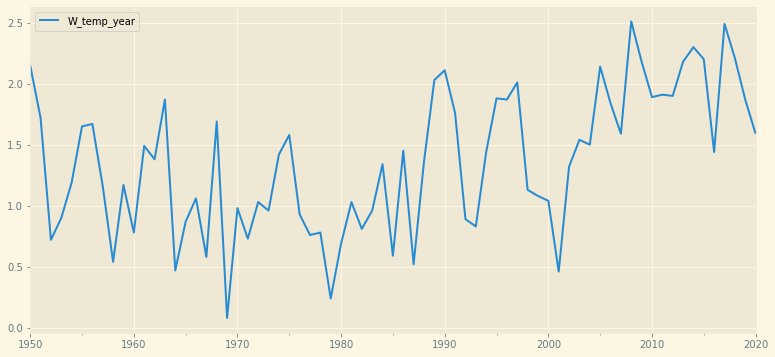

In [2]:
year_raw = pd.read_pickle('./year_raw.pkl')
data = year_raw['W_temp_year']
data.index = pd.to_datetime(data.index, format='%Y')
data = pd.DataFrame(data)
data.plot()

In [3]:
# calculate stationarity test of time series data
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.values, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for k, v in result[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<result[0] else "", 100-int(k[:-1])))
    

# calculate stationarity test of difference time series data
data_diff = data.diff()
data_diff = data_diff.dropna()
result_diff = adfuller(data_diff.values, autolag='AIC')
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for k, v in result_diff[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<result_diff[0] else "", 100-int(k[:-1])))

ADF Statistic: -3.287753
p-value: 0.015435
Critical Values:
	1%: -3.528889992207215 - The data is not stationary with 99% confidence
	5%: -2.9044395987933362 - The data is  stationary with 95% confidence
	10%: -2.589655654274312 - The data is  stationary with 90% confidence
ADF Statistic: -6.614485
p-value: 0.000000
Critical Values:
	1%: -3.5352168748293127 - The data is  stationary with 99% confidence
	5%: -2.9071540828402367 - The data is  stationary with 95% confidence
	10%: -2.5911025443786984 - The data is  stationary with 90% confidence


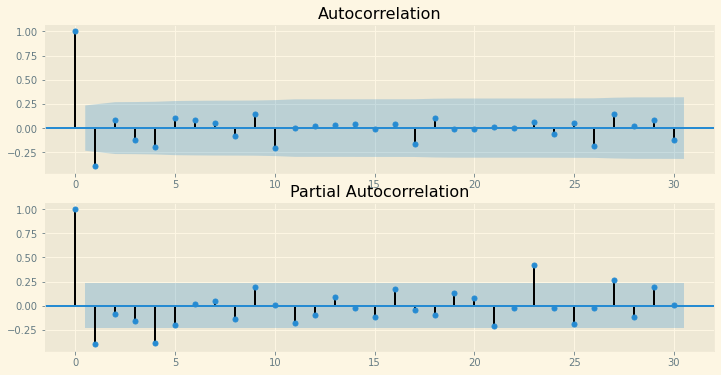

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data_diff, ax=ax[0], lags=30)
ax[1] = plot_pacf(data_diff, ax=ax[1], lags=30)

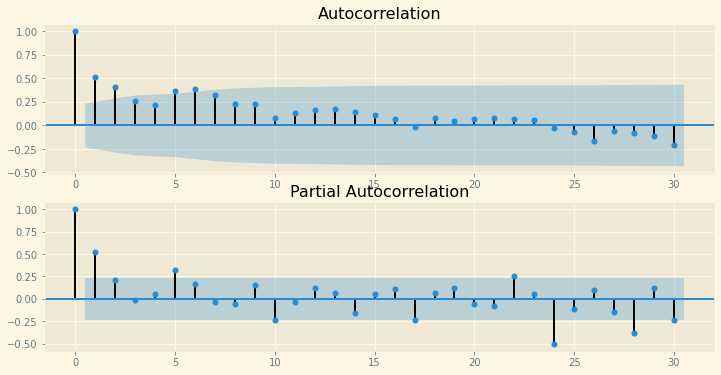

In [5]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data, ax=ax[0], lags=30)
ax[1] = plot_pacf(data, ax=ax[1], lags=30)

# Тестирование базовой модели ARIMA(4,1,4)

               0
count  25.000000
mean    0.036604
std     0.527342
min    -1.203936
25%    -0.174327
50%    -0.018150
75%     0.396912
max     1.109472


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 -40.243
Date:                Mon, 01 Feb 2021   AIC                             98.487
Time:                        09:57:08   BIC                            118.594
Sample:                             0   HQIC                           106.464
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0776      0.523      0.148      0.882      -0.947       1.102
ar.L2         -0.5250      0.194     -2.701      0.007      -0.906      -0.144
ar.L3          0.2263      0.260      0.869      0.385      -0.284       0.737
ar.L4         -0.3652      0.194     -1.882      0.060      -0.745       0.015
ma.L1         -0.6458      0.473     -1.365      0.172      -1.573       0.282
ma.L2          0.6817      0.264      2.577      0.010       0.163       1.200
ma.L3         -0.9331      0.298     -3.127      0.002      -1.518      -0.348
ma.L4          0.3545      0.437      0.812      0.417      -0.501       1.210
sigma2         0.1754      0.036      4.830      0.000       0.104       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.90   Prob(JB):                         0.71
Heteroskedasticity (H):               0.70   Skew:                            -0.17
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

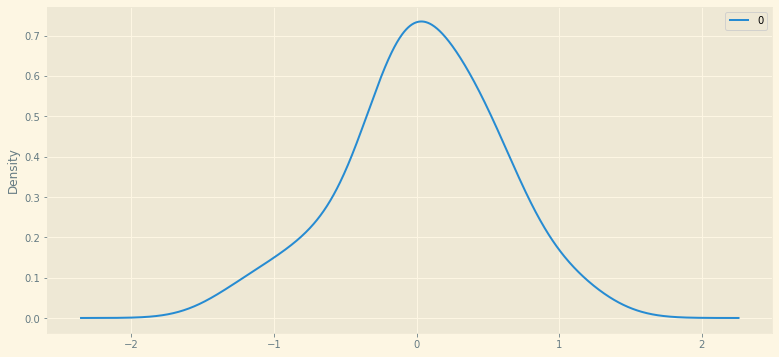

In [6]:
# split into train and test sets
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# walk-forward validation
predictions = []
for t in range(len(test)):
    model_114 = ARIMA(history, order=(4,1,4))
    model_114_fit = model_114.fit()
    output = model_114_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

#residuals describe
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

residuals.plot(kind='kde')

model_114_fit.summary()

In [7]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# report performance with predictions bias
bias = 0.03
predictions_bias = [bias + i for i in predictions]
rmse_bias = sqrt(mean_squared_error(test, predictions_bias))
print('RMSE: %.3f' % rmse)

RMSE: 0.518
RMSE: 0.518


# Best ARIMA(3, 2, 4) RMSE=0.427
# Тестирование выбранной модели ARIMA(3,2,4)

               0
count  25.000000
mean   -0.014697
std     0.438973
min    -0.745999
25%    -0.349033
50%     0.063287
75%     0.312090
max     0.791601


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                 ARIMA(3, 2, 4)   Log Likelihood                 -51.055
Date:                Mon, 01 Feb 2021   AIC                            118.110
Time:                        09:57:26   BIC                            135.867
Sample:                             0   HQIC                           125.146
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7449      0.238     -7.343      0.000      -2.211      -1.279
ar.L2         -1.5091      0.282     -5.345      0.000      -2.062      -0.956
ar.L3         -0.7314      0.191     -3.833      0.000      -1.105      -0.357
ma.L1          0.5667   9.48e+04   5.98e-06      1.000   -1.86e+05    1.86e+05
ma.L2          0.0013   1.48e+05   8.48e-09      1.000   -2.91e+05    2.91e+05
ma.L3         -0.5709   1.49e+05  -3.84e-06      1.000   -2.91e+05    2.91e+05
ma.L4         -0.9970   9.45e+04  -1.06e-05      1.000   -1.85e+05    1.85e+05
sigma2         0.2269   2.15e+04   1.06e-05      1.000   -4.21e+04    4.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.25   Prob(JB):                         0.57
Heteroskedasticity (H):               0.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

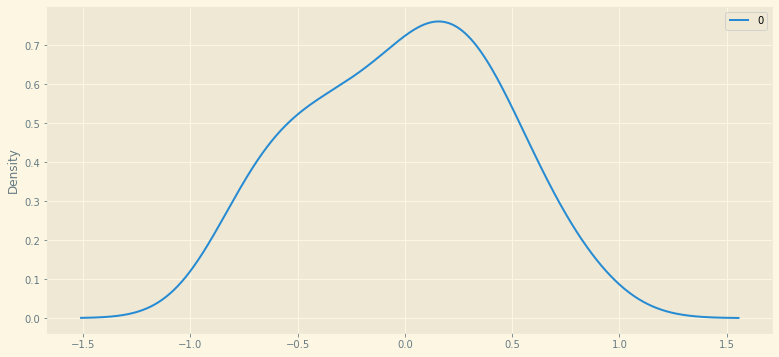

In [8]:
# split into train and test sets
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# walk-forward validation
predictions_324 = []
for t in range(len(test)):
    model_324 = ARIMA(history, order=(3,2,4))
    model_fit_324 = model_324.fit()
    output = model_fit_324.forecast()
    yhat = output[0]
    predictions_324.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

#residuals describe
residuals_324 = [test[i]-predictions_324[i] for i in range(len(test))]
residuals_324 = pd.DataFrame(residuals_324)
print(residuals_324.describe())

residuals_324.plot(kind='kde')

model_fit_324.summary()

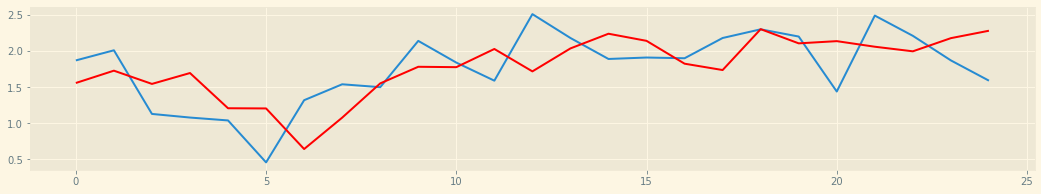

In [9]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions_324, color='red')

# Тестирование выбранной модели по AIC 
# Best AIC ARIMA(0, 1, 5) RMSE=0.448



               0
count  25.000000
mean    0.036604
std     0.527342
min    -1.203936
25%    -0.174327
50%    -0.018150
75%     0.396912
max     1.109472


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                 ARIMA(0, 1, 5)   Log Likelihood                 -42.695
Date:                Mon, 01 Feb 2021   AIC                             97.390
Time:                        09:57:32   BIC                            110.794
Sample:                             0   HQIC                           102.708
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5423      0.107     -5.085      0.000      -0.751      -0.333
ma.L2          0.0817      0.129      0.635      0.526      -0.170       0.334
ma.L3         -0.4626      0.125     -3.692      0.000      -0.708      -0.217
ma.L4         -0.2050      0.129     -1.588      0.112      -0.458       0.048
ma.L5          0.4094      0.131      3.123      0.002       0.152       0.666
sigma2         0.1946      0.037      5.291      0.000       0.123       0.267
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.66   Prob(JB):                         0.65
Heteroskedasticity (H):               0.84   Skew:                            -0.22
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

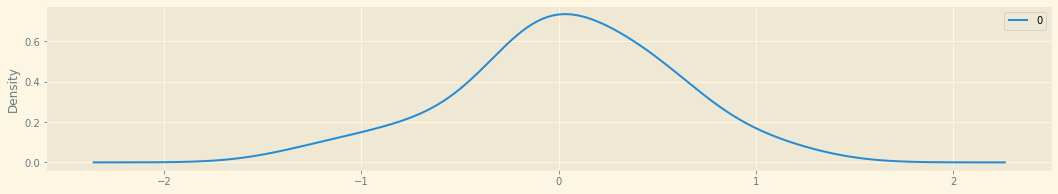

In [10]:
# split into train and test sets
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# walk-forward validation
predictions_015 = []
for t in range(len(test)):
    model_015 = ARIMA(history, order=(0,1,5))
    model_fit_015 = model_015.fit()
    output = model_fit_015.forecast()
    yhat = output[0]
    predictions_015.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

#residuals describe
residuals_015 = [test[i]-predictions_015[i] for i in range(len(test))]
residuals_015 = pd.DataFrame(residuals)
print(residuals_015.describe())

residuals_015.plot(kind='kde')

model_fit_015.summary()

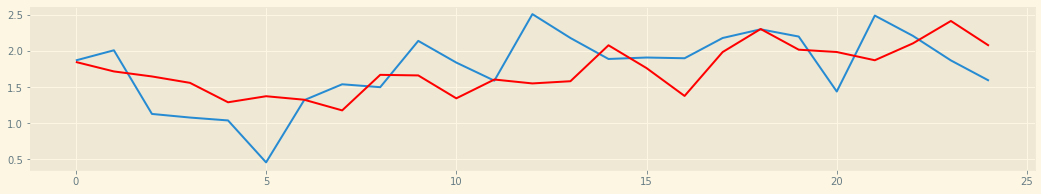

In [11]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions_015, color='red')

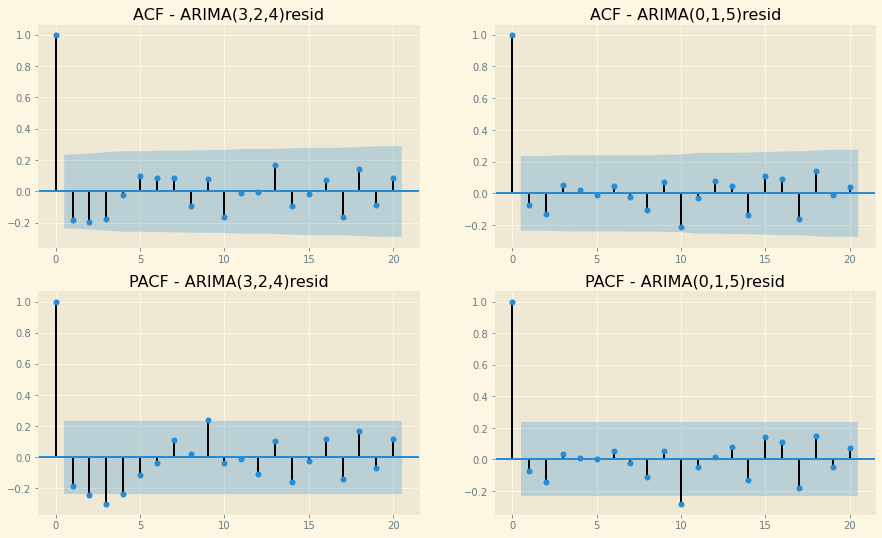

In [12]:
ig, ax = plt.subplots(2, 2, figsize=(15,9))
ax[0, 0] = plot_acf(model_fit_324.resid, ax=ax[0, 0], lags=20, title="ACF - ARIMA(3,2,4)resid")
ax[1, 0] = plot_pacf(model_fit_324.resid, ax=ax[1, 0], lags=20, title="PACF - ARIMA(3,2,4)resid")
ax[0, 1] = plot_acf(model_fit_015.resid , ax=ax[0, 1], lags=20, title="ACF - ARIMA(0,1,5)resid")
ax[1, 1] = plot_pacf(model_fit_015.resid, ax=ax[1, 1], lags=20, title="PACF - ARIMA(0,1,5)resid")

In [13]:
# save test-predictions to exel

train_model = pd.DataFrame({
    'test': test[:,0],
    'Arima(3,2,4)': predictions_324,
    'Arima(0,1,5)': predictions_015
},
    index=(range(1996,2021)))
train_model = train_model.round(2)
train_model


,test,"Arima(3,2,4)","Arima(0,1,5)"
1996,1.87,1.56,1.85
1997,2.01,1.73,1.72
1998,1.13,1.55,1.65
1999,1.08,1.70,1.56
2000,1.04,1.21,1.29
2001,0.46,1.21,1.37
2002,1.32,0.64,1.33
2003,1.54,1.08,1.18
2004,1.50,1.55,1.67
2005,2.14,1.78,1.66


# Forcast ARIMA(3,2,4)


[1.67763199 1.66495758 2.0276395  1.91279301 1.78177231 2.04962619
 1.96711688 1.82818317 2.04772257 2.0035444 ]


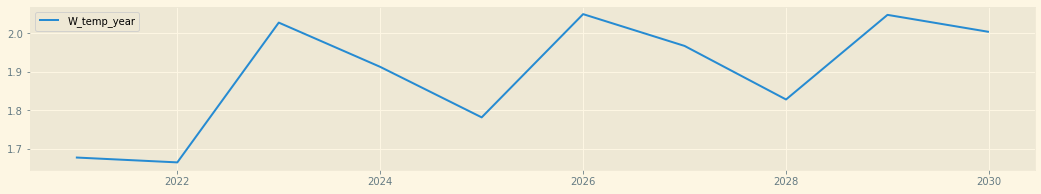

In [14]:
X = data.values
model = ARIMA(X, order=(3,2,4))
res_324 = model.fit()
forecast_324 = res_324.forecast(steps=10)
print(forecast_324)
forc_324 = pd.DataFrame(forecast_324)
forc_324.index = range(2021,2031)
forc_324 = forc_324.rename(columns={0: 'W_temp_year'}, errors='raise')
forc_324.plot()

In [15]:
conf_int = res_324.get_forecast(steps=10)
conf_int = conf_int.conf_int()
conf_int

array([[0.7643695 , 2.59089448],
       [0.65713027, 2.67278489],
       [0.89757914, 3.15769987],
       [0.73057734, 3.09500867],
       [0.58187537, 2.98166925],
       [0.78513827, 3.31411411],
       [0.65961446, 3.2746193 ],
       [0.50307615, 3.15329018],
       [0.66782544, 3.42761971],
       [0.57933208, 3.42775672]])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   71
Model:                 ARIMA(3, 2, 4)   Log Likelihood                 -47.651
Date:                Mon, 01 Feb 2021   AIC                            111.302
Time:                        09:57:36   BIC                            129.175
Sample:                             0   HQIC                           118.393
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4609      0.253     -1.819      0.069      -0.957       0.036
ar.L2         -0.5314      0.275     -1.930      0.054      -1.071       0.008
ar.L3          0.3667      0.241      1.524      0.1

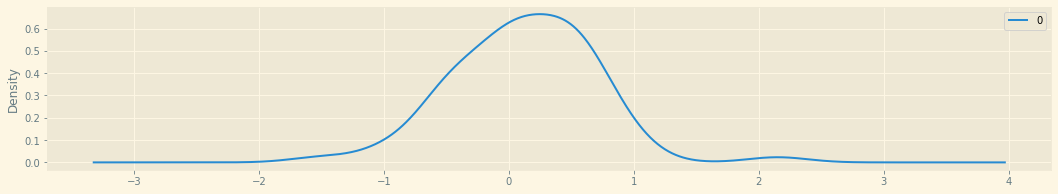

In [16]:
print(res_324.summary())
resid_324 = pd.DataFrame(res_324.resid)
resid_324.plot(kind='kde')

In [17]:
forc_324['conf_down'] = [x[0] for x in conf_int]
forc_324['conf_up'] = [x[1] for x in conf_int]

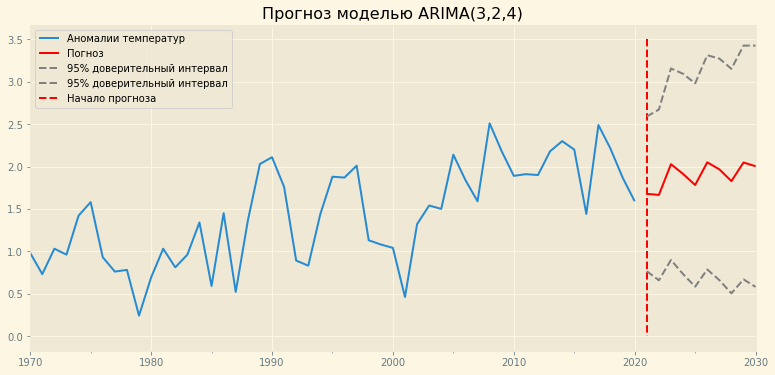

In [18]:
forc_324.index = pd.to_datetime(forc_324.index, format='%Y')

fig, ax = plt.subplots(figsize=(13,6))
data.W_temp_year[20:].plot(ax=ax, label='Аномалии температур')
forc_324.W_temp_year.plot(ax=ax, color='red', label='Погноз')
forc_324.conf_down.plot(ax=ax, color='grey', linestyle='--', label='95% доверительный интервал')
forc_324.conf_up.plot(ax=ax,  color='grey', linestyle='--', label='95% доверительный интервал')
ax.vlines('2021-01-01', 3.5, 0, linestyle='--', color='r', label='Начало прогноза')
plt.title('Прогноз моделью ARIMA(3,2,4)')
plt.legend()

# Forcast ARIMA(0,1,5)



[1.42298112 1.8563496  2.22771369 2.11385149 1.9254433  1.9254433
 1.9254433  1.9254433  1.9254433  1.9254433 ]


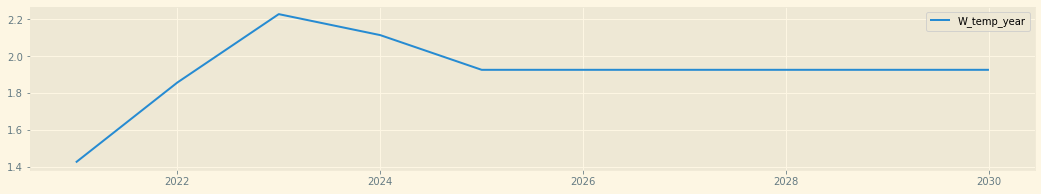

In [19]:
X = data.values
model = ARIMA(X, order=(0,1,5))
res_015 = model.fit()
forecast_015 = res_015.forecast(steps=10)
print(forecast_015)
forc_015 = pd.DataFrame(forecast_015)
forc_015.index = range(2021,2031)
forc_015 = forc_015.rename(columns={0: 'W_temp_year'}, errors='raise')
forc_015.plot()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   71
Model:                 ARIMA(0, 1, 5)   Log Likelihood                 -43.372
Date:                Mon, 01 Feb 2021   AIC                             98.743
Time:                        09:57:38   BIC                            112.234
Sample:                             0   HQIC                           104.102
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5301      0.109     -4.861      0.000      -0.744      -0.316
ma.L2          0.0826      0.128      0.644      0.520      -0.169       0.334
ma.L3         -0.4814      0.123     -3.929      0.0

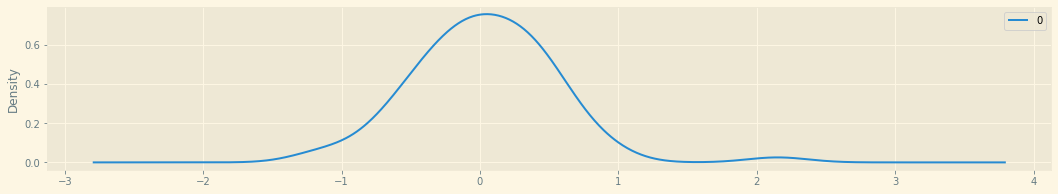

In [20]:
print(res_015.summary())
resid_015 = pd.DataFrame(res_015.resid)
resid_015.plot(kind='kde')

In [21]:
conf_int_015 = res_015.get_forecast(steps=10)
conf_int_015 = conf_int_015.conf_int()
conf_int_015



array([[0.55808307, 2.28787917],
       [0.90073024, 2.81196896],
       [1.15927808, 3.2961493 ],
       [1.04364974, 3.18405325],
       [0.84874364, 3.00214296],
       [0.82372359, 3.02716301],
       [0.79925926, 3.05162733],
       [0.7753152 , 3.0755714 ],
       [0.75185955, 3.09902705],
       [0.7288636 , 3.122023  ]])

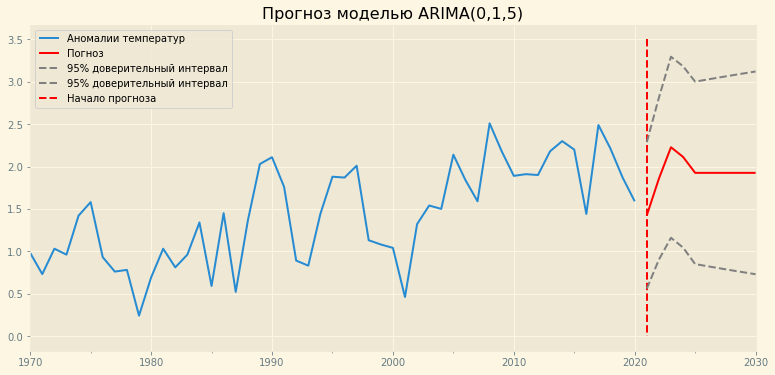

In [22]:
forc_015['conf_down'] = [x[0] for x in conf_int_015]
forc_015['conf_up'] = [x[1] for x in conf_int_015]

forc_015.index = pd.to_datetime(forc_015.index, format='%Y')

fig, ax = plt.subplots(figsize=(13,6))
data.W_temp_year[20:].plot(ax=ax, label='Аномалии температур')
forc_015.W_temp_year.plot(ax=ax, color='red', label='Погноз')
forc_015.conf_down.plot(ax=ax, color='grey', linestyle='--', label='95% доверительный интервал')
forc_015.conf_up.plot(ax=ax,  color='grey', linestyle='--', label='95% доверительный интервал')
ax.vlines('2021-01-01', 3.5, 0, linestyle='--', color='r', label='Начало прогноза')
plt.title('Прогноз моделью ARIMA(0,1,5)')
plt.legend()

In [23]:
# save forecast to exel
forc_324 = forc_324.round(2)
forc_324

,W_temp_year,conf_down,conf_up
2021-01-01,1.68,0.76,2.59
2022-01-01,1.66,0.66,2.67
2023-01-01,2.03,0.90,3.16
2024-01-01,1.91,0.73,3.10
2025-01-01,1.78,0.58,2.98
2026-01-01,2.05,0.79,3.31
2027-01-01,1.97,0.66,3.27
2028-01-01,1.83,0.50,3.15
2029-01-01,2.05,0.67,3.43
2030-01-01,2.00,0.58,3.43


In [24]:
forc_015 = forc_015.round(2)
forc_015

,W_temp_year,conf_down,conf_up
2021-01-01,1.42,0.56,2.29
2022-01-01,1.86,0.90,2.81
2023-01-01,2.23,1.16,3.30
2024-01-01,2.11,1.04,3.18
2025-01-01,1.93,0.85,3.00
2026-01-01,1.93,0.82,3.03
2027-01-01,1.93,0.80,3.05
2028-01-01,1.93,0.78,3.08
2029-01-01,1.93,0.75,3.10
2030-01-01,1.93,0.73,3.12


In [25]:
with pd.ExcelWriter('ARIMA.xlsx') as writer:
    train_model.to_excel(writer, sheet_name='тесты модели', engine='xlsxwriter')
    forc_324.to_excel(writer, sheet_name='прогноз_ARIMA(3,2,4)', engine='xlsxwriter')
    forc_015.to_excel(writer, sheet_name='прогноз_ARIMA(0,1,5)', engine='xlsxwriter')

In [26]:
test

array([[1.87],
       [2.01],
       [1.13],
       [1.08],
       [1.04],
       [0.46],
       [1.32],
       [1.54],
       [1.5 ],
       [2.14],
       [1.84],
       [1.59],
       [2.51],
       [2.18],
       [1.89],
       [1.91],
       [1.9 ],
       [2.18],
       [2.3 ],
       [2.2 ],
       [1.44],
       [2.49],
       [2.21],
       [1.87],
       [1.59]])